In [1]:
# =========================
# STEP 0: Imports
# =========================
import numpy as np
import pandas as pd

from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re


In [2]:
# =========================
# STEP 1: Upload & load the Excel file; peek at columns
# =========================
uploaded = files.upload()
filename = list(uploaded.keys())[0]

df = pd.read_excel(filename)

print("First 5 rows:")
display(df.head())

print("\nOriginal columns:")
print(list(df.columns))


Saving final_nhs-wq_pre_2023_compressed.xlsx to final_nhs-wq_pre_2023_compressed.xlsx
First 5 rows:


,S. No.,State,District,Location,Longitude,Latitude,Year,pH,EC (µS/cm at,CO3 (mg/L),...,NO3,PO4,Total Hardness,Ca (mg/L),Mg (mg/L),Na (mg/L),K (mg/L),Fe (ppm),As (ppb),U (ppb)
0,1,Andaman & Nicobar Islands,North & Middle Andaman,Bakultala,92.8577,12.5043,2023,7.96,395,0,...,8,0.04,160,12,32,18,5,0.53,-,-
1,2,Andaman & Nicobar Islands,North & Middle Andaman,Baratang (Nilambur),92.767,12.1683,2023,8.19,473,0,...,10,0.03,135,26,17,39,5,0,-,-
2,3,Andaman & Nicobar Islands,North & Middle Andaman,Basantipur,92.8737,12.7579,2023,8.19,556,0,...,1,0.05,230,38,33,22,1,0.22,-,-
3,4,Andaman & Nicobar Islands,North & Middle Andaman,Betapur,92.9434,12.6191,2023,8.07,487,0,...,2,0.08,95,18,12,68,8,0.04,-,-
4,5,Andaman & Nicobar Islands,North & Middle Andaman,Dhobidera (Mayabunder),92.8992,12.9099,2023,8.02,567,0,...,11,0.04,230,28,39,31,1,0.22,-,-



Original columns:
['S. No.', 'State', 'District', 'Location', 'Longitude', 'Latitude', 'Year', 'pH', 'EC (µS/cm at', 'CO3 (mg/L)', 'HCO3', 'Cl (mg/L)', 'F (mg/L)', 'SO4', 'NO3', 'PO4', 'Total Hardness', 'Ca (mg/L)', 'Mg (mg/L)', 'Na (mg/L)', 'K (mg/L)', 'Fe (ppm)', 'As (ppb)', 'U (ppb)']


In [5]:
# =========================
# STEP 3: Build a clean numeric frame of the features we care about
#         and handle NaN / inf safely
# =========================
# Collect the columns we will use anywhere (labels or features)
logical_cols = [c for c in detected.values() if c is not None]

# Coerce to numeric where possible (keeps non-matching as NaN)
num_df = df[logical_cols].apply(pd.to_numeric, errors="coerce")

# Replace ±inf with NaN (then impute later in the pipeline)
num_df = num_df.replace([np.inf, -np.inf], np.nan)

# For label creation, we need actual values for pH, NO3, Hardness; drop rows missing them
label_cols = [detected["pH"], detected["NO3"], detected["Hardness"]]
label_ready = num_df.dropna(subset=label_cols).copy()

print(f"Rows after ensuring pH/NO3/Hardness present for labeling: {label_ready.shape[0]}")


Rows after ensuring pH/NO3/Hardness present for labeling: 15258


In [6]:
# =========================
# STEP 4: Create proxy labels (rule-based) WITHOUT using TDS
# =========================
def classify_water_row(row, colmap):
    pH = row[colmap["pH"]]
    NO3 = row[colmap["NO3"]]
    Hardness = row[colmap["Hardness"]]
    if (6.5 <= pH <= 8.5) and (NO3 <= 45) and (Hardness <= 200):
        return "Drinking"
    else:
        return "Unsafe"

label_ready["Label"] = label_ready.apply(
    lambda r: classify_water_row(r, {"pH": detected["pH"], "NO3": detected["NO3"], "Hardness": detected["Hardness"]}),
    axis=1
)

print("Label counts:")
print(label_ready["Label"].value_counts())


Label counts:
Label
Unsafe      11076
Drinking     4182
Name: count, dtype: int64


In [7]:
# =========================
# STEP 5: Build the ML dataset WITHOUT leakage
#         (drop pH, NO3, Hardness from features; keep the rest)
# =========================
# Map canonical->actual again for convenience
actual = detected

# Candidate feature columns (others that were detected and exist)
candidate_features = []
for k in ["EC (µS/cm)", "Cl (mg/L)", "F (mg/L)", "SO4", "Fe (ppm)", "As (ppb)"]:
    if actual.get(k) is not None:
        candidate_features.append(actual[k])

print("Training features (no leakage):", candidate_features)

X = label_ready[candidate_features].copy()
y = label_ready["Label"].copy()

# Train/val split with stratify to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Training features (no leakage): ['EC (µS/cm at', 'Cl (mg/L)', 'SO4', 'Fe (ppm)', 'As (ppb)']


=== Random Forest ===
              precision    recall  f1-score   support

    Drinking       0.82      0.74      0.78       837
      Unsafe       0.91      0.94      0.92      2215

    accuracy                           0.89      3052
   macro avg       0.86      0.84      0.85      3052
weighted avg       0.88      0.89      0.88      3052



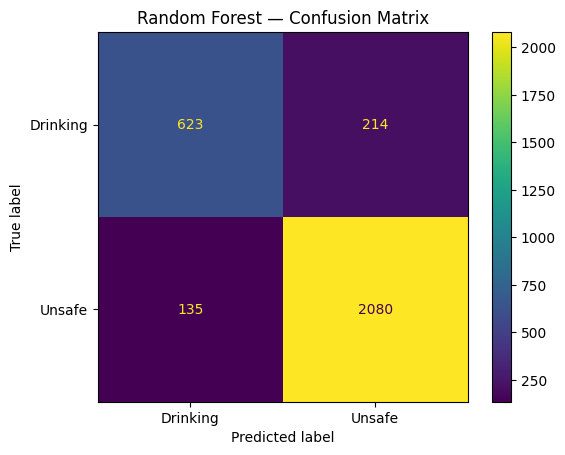


Random Forest feature importances:


,importance
EC (µS/cm at,0.536945
Cl (mg/L),0.186200
SO4,0.169985
Fe (ppm),0.060674
As (ppb),0.046195


from matplotlib import pyplot as plt
_df_0['importance'].plot(kind='hist', bins=20, title='importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['importance'].plot(kind='line', figsize=(8, 4), title='importance')
plt.gca().spines[['top', 'right']].set_visible(False)

In [9]:
# =========================
# STEP 6A: RANDOM FOREST pipeline (robust, no scaling needed)
# =========================
rf_clf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(n_estimators=300, random_state=42))
])

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=rf_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_clf.classes_)
disp.plot(values_format='d')
plt.title("Random Forest — Confusion Matrix")
plt.show()

# Feature importances
try:
    importances = rf_clf.named_steps["rf"].feature_importances_
    feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    print("\nRandom Forest feature importances:")
    display(feat_importance.to_frame("importance"))
except Exception as e:
    print("Could not compute RF importances:", e)


In [12]:
# =========================
# STEP 7: Make a sample prediction (aligns columns automatically)
# NOTE: Sample should include ONLY the non-leakage feature columns we trained on.
# =========================
sample_full = pd.DataFrame([{
    # pH/NO3/Hardness intentionally omitted from features to avoid leakage.
    # If you still include them here, we'll drop them below to match model inputs.
    actual["EC (µS/cm)"]: 1500 if actual.get("EC (µS/cm)") else np.nan,
    actual["Cl (mg/L)"]: 60 if actual.get("Cl (mg/L)") else np.nan,
    actual["F (mg/L)"]: 0.9 if actual.get("F (mg/L)") else np.nan,
    actual["SO4"]: 100 if actual.get("SO4") else np.nan,
    actual["Fe (ppm)"]: 0.2 if actual.get("Fe (ppm)") else np.nan,
    actual["As (ppb)"]: 0.01 if actual.get("As (ppb)") else np.nan
}])

# Align columns with training features
sample = sample_full.reindex(columns=X.columns)

pred_rf = rf_clf.predict(sample)[0]
pred_log = log_clf.predict(sample)[0]

print(f"RF prediction:  {pred_rf}")
print(f"LogReg prediction: {pred_log}")

def suggest_alternatives(label):
    if label == "Drinking":
        return ["Drinking", "Cooking", "Household use"]
    elif label == "Irrigation":
        return ["Irrigation", "Livestock use"]
    elif label == "Industrial":
        return ["Cooling water", "Construction", "Non-sensitive cleaning"]
    else:  # Unsafe
        return ["Construction (cement mixing, road work)", "Non-sensitive industrial uses"]

print("Suggested alternatives (RF):", suggest_alternatives(pred_rf))


RF prediction:  Unsafe
LogReg prediction: Unsafe
Suggested alternatives (RF): ['Construction (cement mixing, road work)', 'Non-sensitive industrial uses']


In [20]:
import joblib

# Save the trained model
joblib.dump(rf_clf, "SafeOrNot_model.pkl")

['SafeOrNot_model.pkl']

In [22]:
from google.colab import files
files.download("SafeOrNot_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import joblib
import pandas as pd
import numpy as np

# Load the trained model
loaded_model = joblib.load("SafeOrNot_model.pkl")

# Create new sample data for prediction (make sure columns match training data)
# Replace these sample values with your actual new data
new_sample_data = pd.DataFrame([{
    'EC (µS/cm at': 500,
    'Cl (mg/L)': 50,
    'SO4': 30,
    'Fe (ppm)': 0.1,
    'As (ppb)': 0.05
}])

# Make a prediction using the loaded model
prediction = loaded_model.predict(new_sample_data)

print(f"Prediction for new sample data: {prediction[0]}")

def suggest_alternatives(label):
    if label == "Drinking":
        return ["Drinking", "Cooking", "Household use"]
    elif label == "Irrigation":
        return ["Irrigation", "Livestock use"]
    elif label == "Industrial":
        return ["Cooling water", "Construction", "Non-sensitive cleaning"]
    else:  # Unsafe
        return ["Construction (cement mixing, road work)", "Non-sensitive industrial uses"]

print("Suggested alternatives:", suggest_alternatives(prediction[0]))

In [23]:
print(X.columns)



Index(['EC (µS/cm at', 'Cl (mg/L)', 'SO4', 'Fe (ppm)', 'As (ppb)'], dtype='object')
